In [28]:
import pickle
from topolearn import *
import numpy as np
import pandas as pd

s = 1
K0_coll = np.arange(5, 26, 4)
nu = 62
# Plot test error curves
curves_params = {"dictionary_type": "separated",
                 "test_error": True, 
                 "prob_T": 0.2, 
                 "sparsity_mode":"random", 
                 "sparsity":25,
                 "mode":"optimistic",
                 "algo_sparsity": K0_coll[s]}

name = f'max_sparsity{curves_params["sparsity"]}' if curves_params["sparsity_mode"]=="max" else f'random_sparsity{curves_params["sparsity"]}'
with open(f'results\\final\\{name}\\res_{curves_params["dictionary_type"]}_T{int(curves_params["prob_T"]*100)}.pkl', "rb") as file:
    models = pickle.load(file)
    res = pickle.load(file)

In [29]:
models["9,0"].get_numb_triangles("optimistic")

47

In [2]:
import pickle

with open("C:\\Users\\engri\\Desktop\\tesi\\TSP-DictionaryLearning\\results\\final\\random_sparsity25\\res_separated_T20_pess.pkl", "rb") as file:
    pess_models = pickle.load(file)
    _ = pickle.load(file)

In [10]:
pess_models[(9, 0)]

In [22]:
pess_models.keys()

dict_keys([(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5)])

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import networkx as nx
import pandas as pd
import numpy as np
from topolearn.utils import save_plot
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

@save_plot
def plot_changepoints_curve(
    history,
    nu,
    burn_in: float = 0,
    a=0.1,
    b=0.1,
    c=0.9,
    d=0.01,
    yscale: str = "log",
    sparse_plot=False,
    include_burn_in=False,
    step_h=1.0,
    step_x=1.0,
    change_region_len=3,
    **kwargs,
):

    mode = kwargs.get("mode", "optimistic")
    p = kwargs.get("prob_T")
    k0 = kwargs.get("algo_sparsity")
    T = int(np.ceil(nu * (1 - p)))
    start_iter = 0
    end_iter = 0
    change_points = []
    change_points_y1 = []
    change_points_y2 = []
    burn_in_iter = 0
    his = []
    xx = []
    for i, h in enumerate(history):
        if i == 0:
            burn_in_iter = int(np.ceil(burn_in * len(h)))
        his += h
        end_iter += len(h) - 1
        tmp = range(start_iter, end_iter + 1)
        xx += tmp
        start_iter = end_iter
        change_points.append(end_iter)
        change_points_y1.append(h[-1])
        change_points_y2.append(h[0])

    plt_data = pd.DataFrame({"y": his[burn_in_iter:], "x": xx[burn_in_iter:]})

    change_points = np.array(change_points[:-1])
    change_points_y1 = np.array(change_points_y1[:-1])
    change_points_y2 = np.array(change_points_y2[1:])
    # change_points_y = plt_data[plt_data['x'].isin(change_points)].y.to_numpy()[np.arange(0, len(change_points), 1)]

    my_fig = plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid", {"grid.color": ".6", "grid.linestyle": ":"})

    my_plt = sns.lineplot(x=plt_data["x"], y=plt_data["y"], estimator=None, sort=False)

    labels = (
        ("removing", "Optimistic")
        if mode == "optimistic"
        else ("adding", "Pessimistic")
    )
    # Change-points
    sns.scatterplot(
        x=np.hstack([change_points, change_points]),
        y=np.hstack([change_points_y1, change_points_y2]),
        label=f"Change Point: optimally {labels[0]} \n a triangle from Upper Laplacian.",
        color="purple",
        marker="d",
    )

    plt.vlines(
        x=change_points,
        color="lightblue",
        linestyle="dotted",
        ymax=change_points_y1,
        ymin=change_points_y2,
    )

    # Burn-in area
    plt.axvspan(0, burn_in_iter, color="grey", alpha=0.2, hatch="//")

    if include_burn_in:
        x0, xmax = plt.xlim()
    else:
        x0, xmax = plt.xlim()
        x0 = burn_in_iter

    y0, ymax = plt.ylim()

    # my_plt.set_title(f"{labels[1]} topology learning", fontsize=16, pad=25)
    # plt.suptitle(
    #     f"Assumed signal sparsity: {k0}  -  Step size h: {step_h}  -  Step size X: {step_x}",
    #     fontsize=12,
    #     # color="gray",
    #     x=0.5,
    #     y=0.92,
    # )
    if burn_in_iter > 0.:
        plt.text(
            y=ymax * a,
            x=xmax * b,
            s=f"Burn-in: {burn_in_iter} iters.",
            fontsize=15,
            color="gray",
        )
    ni = nu - change_points.shape[0] if mode=="optimistic" else change_points.shape[0]
    operation = "removed" if mode=="optimistic" else "added"
    plt.text(
        s=f" Number of {operation} triangles: {ni} \n Number of true triangles: {nu-T}",
        y=ymax * c,
        x=xmax * d,
        fontsize=12,
        color="purple",
    )
    my_plt.set_xlabel("Iteration")

    if sparse_plot:
        tmp_vector = np.ones(len(change_points))
        tmp_vector[1::2] = 0
        plt.xticks(change_points * tmp_vector)
    else:
        if change_points.shape[0] > 1:
            plt.xticks(change_points)
    plt.xlim(left=x0, right=xmax)

    if yscale == "log":
        my_plt.set_ylabel("NMSE (Log Scale)")
        plt.yscale("log")
    else:
        my_plt.set_ylabel("NMSE")

    plt.yticks([])

    # Identify the region where y-values change slowly
    if change_region_len==0:
        y_diff = np.abs(np.diff(plt_data["y"]))
        slow_change_indices = np.where(y_diff < 1e-2)[0]

        if len(slow_change_indices) > 0:
            # Select the first significant region of slow change
            zoom_start = slow_change_indices[0]
            zoom_end = slow_change_indices[-1]

            sns.lineplot(
            x=plt_data["x"].iloc[zoom_start:],
            y=plt_data["y"].iloc[zoom_start:],
            estimator=None,
            sort=False,
            ax=ax_inset,
            )
    elif change_region_len==None:
        pass
    else:
        zoom_start = change_points[-change_region_len]
        # zoom_end = len(plt_data["x"])-1
        # Create inset axes for zoomed-in region
        ax_inset = inset_axes(
            my_plt, width="50%", height="40%", loc="center right", borderpad=2
        )
        sns.lineplot(
            x=plt_data["x"].iloc[zoom_start:],
            y=plt_data["y"].iloc[zoom_start:],
            estimator=None,
            sort=False,
            ax=ax_inset,
        )
        # Change-points
        sns.scatterplot(
            x=np.hstack([change_points[-change_region_len:], change_points[-change_region_len:]]),
            y=np.hstack([change_points_y1[-change_region_len:], change_points_y2[-change_region_len:]]),
            color="purple",
            marker="d",
        )


    # Set limits for the zoomed-in region
    # print(zoom_end)
    # print(plt_data["x"].iloc[zoom_end])
    # ax_inset.set_xlim(plt_data["x"].iloc[zoom_start], plt_data["x"].iloc[zoom_end])
    # ax_inset.set_ylim(
    #     plt_data["y"].iloc[zoom_start:].min(),
    #     plt_data["y"].iloc[zoom_start:].max(),
    # )
    ax_inset.set_xlabel(None)
    ax_inset.set_ylabel(None)
    # ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    if yscale == "log":
        ax_inset.set_yscale("log")
    # ax_inset.set_title("Zoomed-in region", fontsize=10)

    return my_fig

In [26]:
nu

62

In [31]:
models[f"9,{s}"].get_numb_triangles("optimistic")

42

In [25]:
62-16

46

Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\random_sparsity25\topocp_learning_curve_T20_S9.png


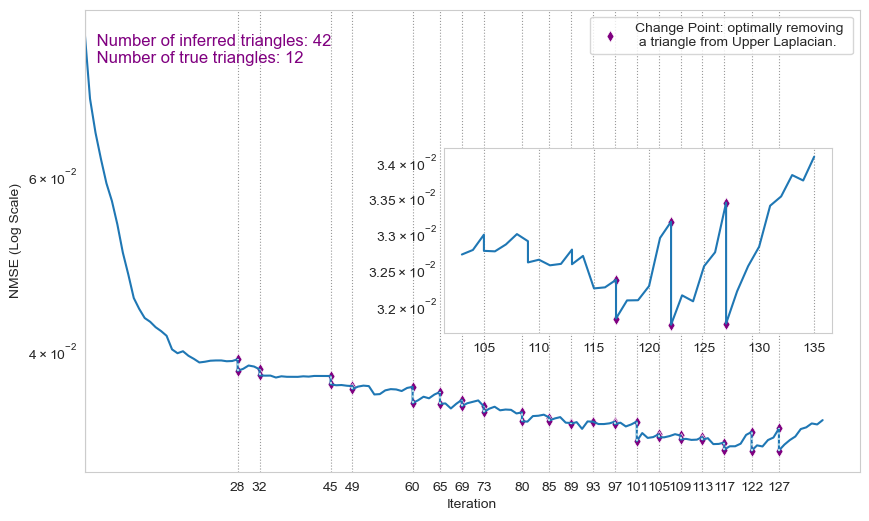

In [34]:
hist = models[f"9,{s}"].train_history
pess_hist = pess_models[(9,s)][0].train_history
plot_changepoints_curve(hist,
                        nu,
                        **curves_params)

In [24]:
len(hist)

16

Plot saved to c:\Users\engri\Desktop\tesi\TSP-DictionaryLearning\plots\final\random_sparsity25\topocp_learning_curve_T20_S9_pess.png


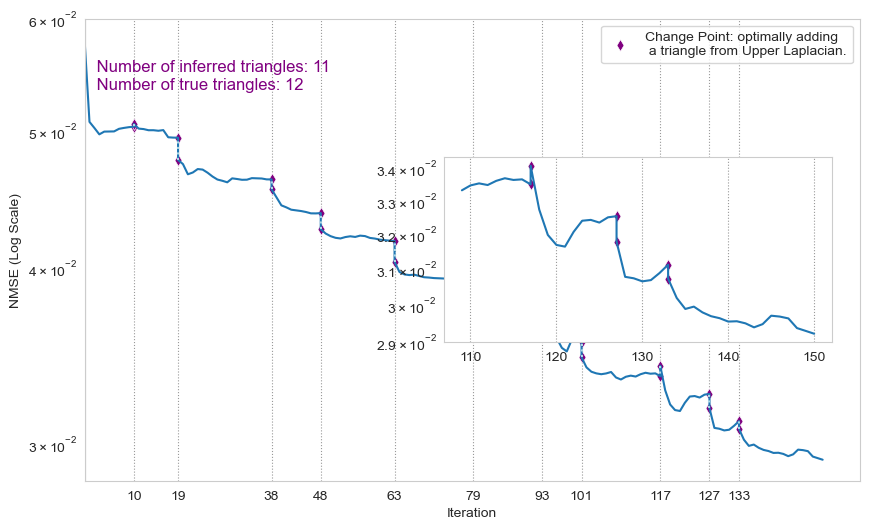

In [38]:
curves_params["mode"] = "pessimistic"

plot_changepoints_curve(pess_hist,
                        nu,
                        **curves_params)

In [39]:
import scipy.io
mat = scipy.io.loadmat('data_real.mat')

In [48]:
mat["B1"].shape

(50, 89)

In [44]:
mat["B2"].shape

(89, 39)

In [47]:
mat["signal_edge"].shape

(89, 28)

number of edges: 89

number of triangles: 28

number of nodes: 50